# Проект: Исследование продаж по игровым платформам.

## Описание проекта

*Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.*

*Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й.*

# Шаг 1. Изучение общей информации

In [1]:
#загружаем библиотеки
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from scipy import stats as st



import warnings # отключаем "бесполезные" предупреждения 
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('/datasets/games.csv')

df.info()#изучаем общую информацию

display(df.describe())

display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**Видим, что названия столбцов "неправильные", кое-где есть пропуски, год релиза - число не целое, есть непонятная оценка "tbd" в оценках пользователей и тип оценки -"object".**

# Шаг 2.  Подготовка данных

In [3]:
df.columns = df.columns.str.lower() #приводим названия столбцов к нижнему регистру

df.dropna(subset = ['name'], inplace=True) #т.к. количество объектов, где не указано название игры слишком мало, просто удаляем эти строки 
df.dropna(subset = ['year_of_release'], inplace=True) #т.к. количество объектов, где не указан год релиза слишком мало, просто удаляем эти строки 

df['year_of_release'] = df['year_of_release'].astype(int)#меняем вещественные значения столбца год релиза на целые, т.к. это логично("номер года" - ЦЕЛОЕ число)

#print(df['user_score'].unique())
df.loc[df['user_score'] == 'tbd', 'user_score'] = float('nan') #меняем "To Be Determined" значение в оценке на 'nan'
df['user_score'] = df['user_score'].astype(float) # переводим значения в 'float', т.к. оценка это все-таки число

df['global_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']#добавляем в таблицу суммарные продажи 

df.info()
display(df.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             9768 non-null object
global_sales       16444 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


**Привели данные к виду, с которым уже можно работать.**

# Шаг 3. Исследовательский анализ данных

# Шаг 3.1

,count
year_of_release,
2016,502
2015,606
2014,581
2013,544
2012,653
2011,1136
2010,1255
2009,1426
2008,1427


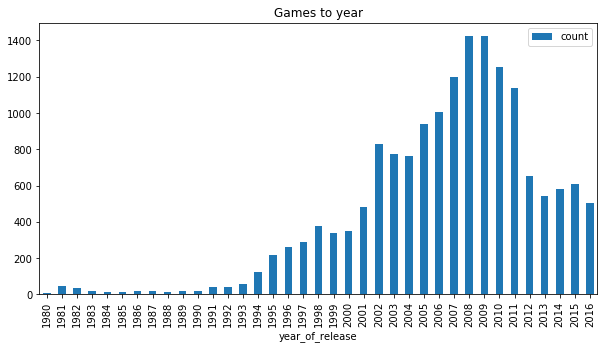

In [4]:
#print(df['year_of_release'].unique())

#создаем сводную таблицу для определения количества выпущенных игр по годам

df_year_count = df.pivot_table(index = ['year_of_release'], values = 'name', aggfunc = 'count') 
df_year_count = df_year_count.rename(columns = {'name':'count'}) 

display(df_year_count.sort_values(by='year_of_release', ascending=False))

df_year_count.plot(kind = 'bar', title = 'Games to year', figsize = (10,5))
plt.show()

**В период 1980-1993г. была выпущена 351 игра, это примерно 25 в год. В период 1994-2001г. была выпущена 2441 игра, это примерно 305 в год. В период 2002-2006г. - 4311 игр, примерно 862 в год. В 2007-2011г. - 6441 игра, примерно 1288 в год. В 2012-2016г. - 2886 игр, примерно 577 в год.**

**Я думаю что для прогнозов достаточно будет последних 4-х лет. Т.к. в эти годы выпускалось примерно одинаковое количество игр.**

# Шаг 3.2

In [5]:
print(df['platform'].unique())

df_platform_sales = df.pivot_table(index = ['platform'], values = 'global_sales', aggfunc = 'sum')
display(df_platform_sales.sort_values(by='global_sales', ascending=False))


['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']


,global_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


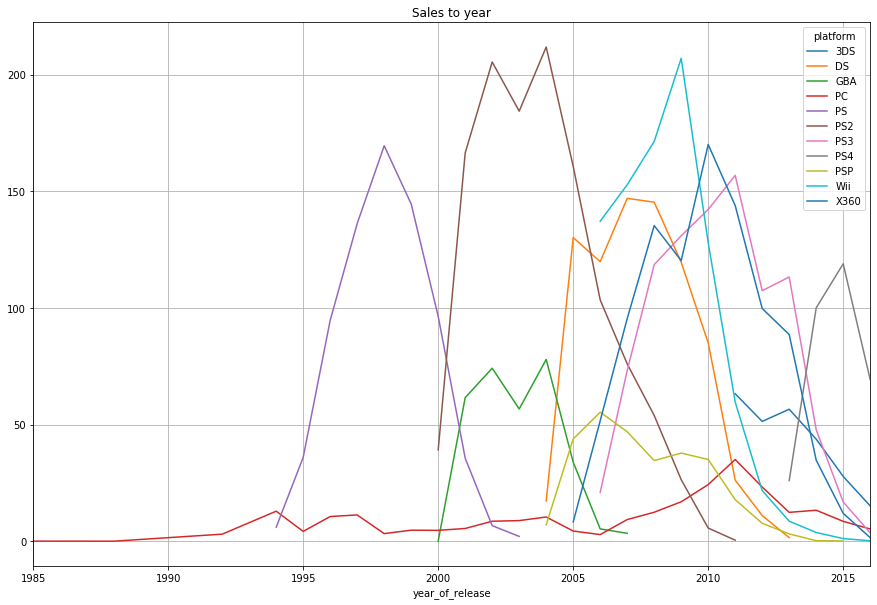

In [6]:
#создаем список топ платформ
top_platforms = ['PS2','X360','PS3','Wii','DS','PS','PS4','GBA','PSP','3DS','PC']

#создаем сводную таблицу с топ платформами
df_top_platforms = df.query('platform in @top_platforms').pivot_table(index='year_of_release', columns = 'platform', values='global_sales', aggfunc='sum')

#строим графики продаж топ платформ по годам
df_top_platforms.plot(grid=True, title = 'Sales to year', figsize=(15, 10))
plt.show()

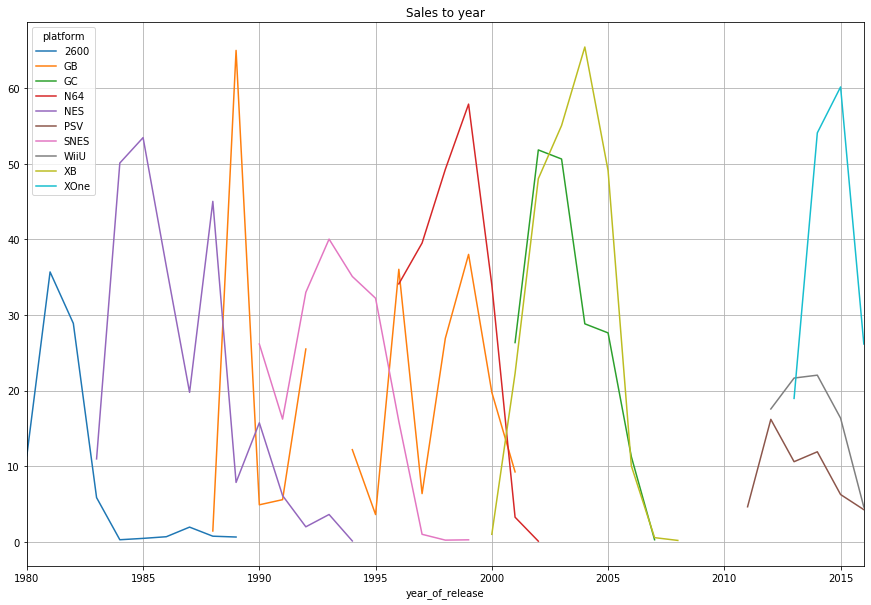

In [7]:
#создаем список "не топ платформ", но еще и "не дно"
middle_platforms = ['GB','XB','NES','N64','SNES','GC','XOne','2600','WiiU','PSV']

#создаем сводную таблицу с платформами, средними по продажам
df_middle_platforms = df.query('platform in @middle_platforms').pivot_table(index='year_of_release', columns = 'platform', values='global_sales', aggfunc='sum')

#строим графики продаж "нетоп" платформ по годам
df_middle_platforms.plot(grid=True, title = 'Sales to year', figsize=(15, 10))
plt.show()

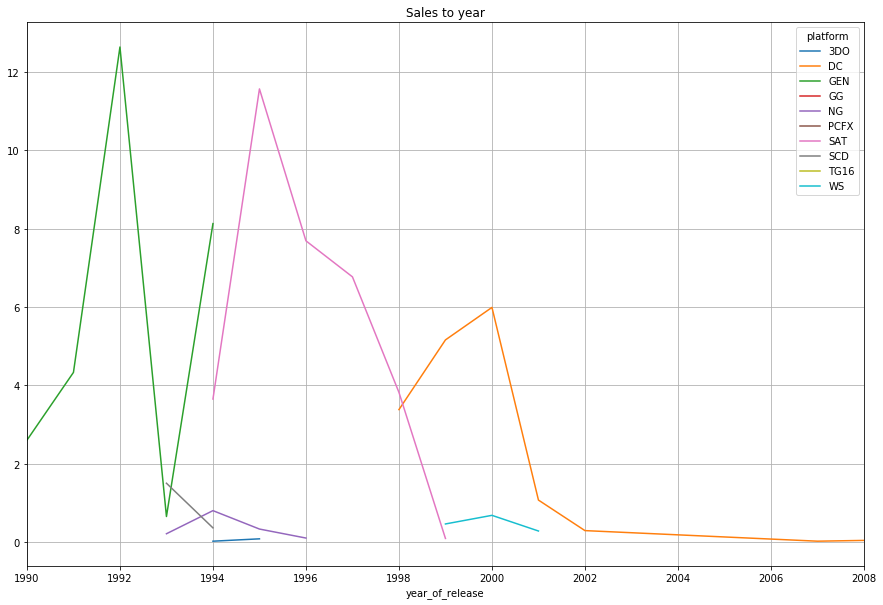

In [8]:
#на "всякий" случай создаем список "дно-платформ"
bottom_platforms = ['SAT','GEN','DC','SCD','NG','WS','TG16','3DO','GG','PCFX']

#создаем сводную таблицу с "дно-платформами"
df_bottom_platforms = df.query('platform in @bottom_platforms').pivot_table(index='year_of_release', columns = 'platform', values='global_sales', aggfunc='sum')

#строим графики продаж "дно" платформ по годам
df_bottom_platforms.plot(grid=True, title = 'Sales to year', figsize=(15, 10))
plt.show()

**Как и следовало ожидать, "дноплатформы" нам не интересны, т.к. давно утратили свою актуальность.**

**Некоторые платформы еще входят в топ по продажам, но это продажи прошлых лет, игры на этих платформах уже не продаются.**

**Если бы я не построил график платформ со средними продажами, то можно было пропустить актуальные платформы, которые еще не израсходовали свой потенциал, такие как "PSV","WiiU" и "Xbox One".**

**Средний срок "жизни" платформы, согласно графикам, примерно 10 лет, но есть "РС", который "вечен".**

# Шаг 3.3

*Актуальный период возьмем 2013-2016 годы, за этот период выпускалось примерно одинаковое количество игр.*

In [9]:
df_topical = df.query('year_of_release>2012') # оставляем в таблице "актуальные" данные 
df_topical.info()
display(df_topical.head(20))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233 entries, 16 to 16714
Data columns (total 12 columns):
name               2233 non-null object
platform           2233 non-null object
year_of_release    2233 non-null int64
genre              2233 non-null object
na_sales           2233 non-null float64
eu_sales           2233 non-null float64
jp_sales           2233 non-null float64
other_sales        2233 non-null float64
critic_score       991 non-null float64
user_score         1192 non-null float64
rating             1256 non-null object
global_sales       2233 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 226.8+ KB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24
69,Call of Duty: Ghosts,PS3,2013,Shooter,4.10,3.63,0.38,1.25,71.0,2.6,M,9.36
72,Minecraft,X360,2013,Misc,5.70,2.65,0.02,0.81,NaN,NaN,NaN,9.18
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58


# Шаг 3.4

In [10]:
#print(df_topical['platform'].unique())
#создаем сводную таблицу глобальных продаж по платформам
df_topical_platform_sales = df_topical.pivot_table(index = ['platform'], values = 'global_sales', aggfunc = 'sum')

#добавляем столбец с процентами от общего количества
df_topical_platform_sales['%'] = (df_topical_platform_sales['global_sales'] / df_topical_platform_sales['global_sales'].sum() * 100).round(1)
display(df_topical_platform_sales.sort_values(by='global_sales', ascending=False))

,global_sales,%
platform,,
PS4,314.14,28.8
PS3,181.43,16.6
XOne,159.32,14.6
3DS,143.25,13.1
X360,136.80,12.5
WiiU,64.63,5.9
PC,39.43,3.6
PSV,32.99,3.0
Wii,13.66,1.3


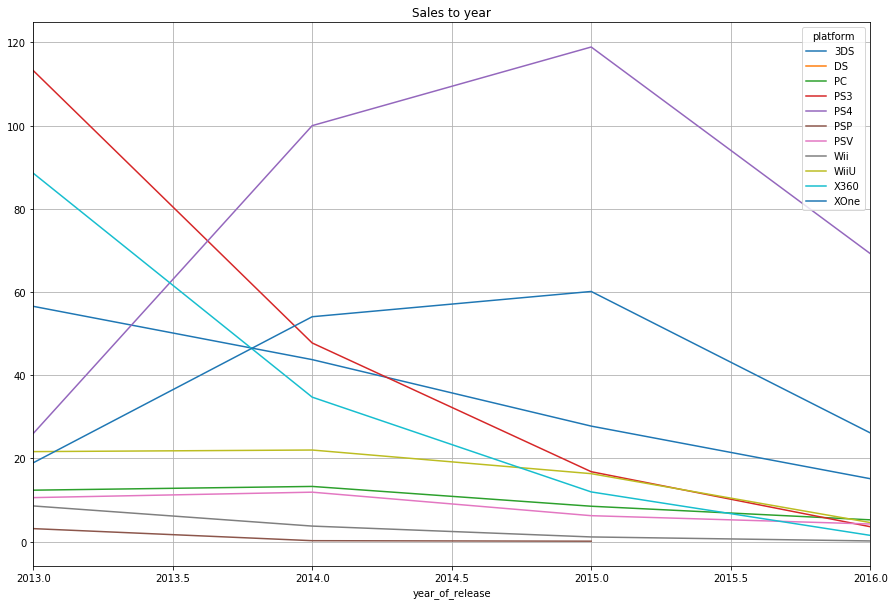

In [11]:
#строим график продаж платформ по годам
df_topical.pivot_table(index='year_of_release', columns = 'platform', values='global_sales', aggfunc='sum').plot(grid=True,title = 'Sales to year',  figsize=(15, 10))
plt.show()

**Несомненно лидируют по продажам платформы "PlayStation 4","PlayStation 3","Xbox One","Nintendo 3DS" и "Xbox360".На долю продаж игр этих платформ приходится примерно 85,6%. Явные лидеры : "PlayStation 4" и "PlayStation 3", на долю продаж игр этих платформ приходится 28,8% и 16,3% соответственно.**

**Но согласно графику с 2015 года практически у всех платформ продажи падают. Отдельной строкой можно отметить "РС", на протяжении почти 30 лет продажи примерно в "одной поре".**

# Шаг 3.5

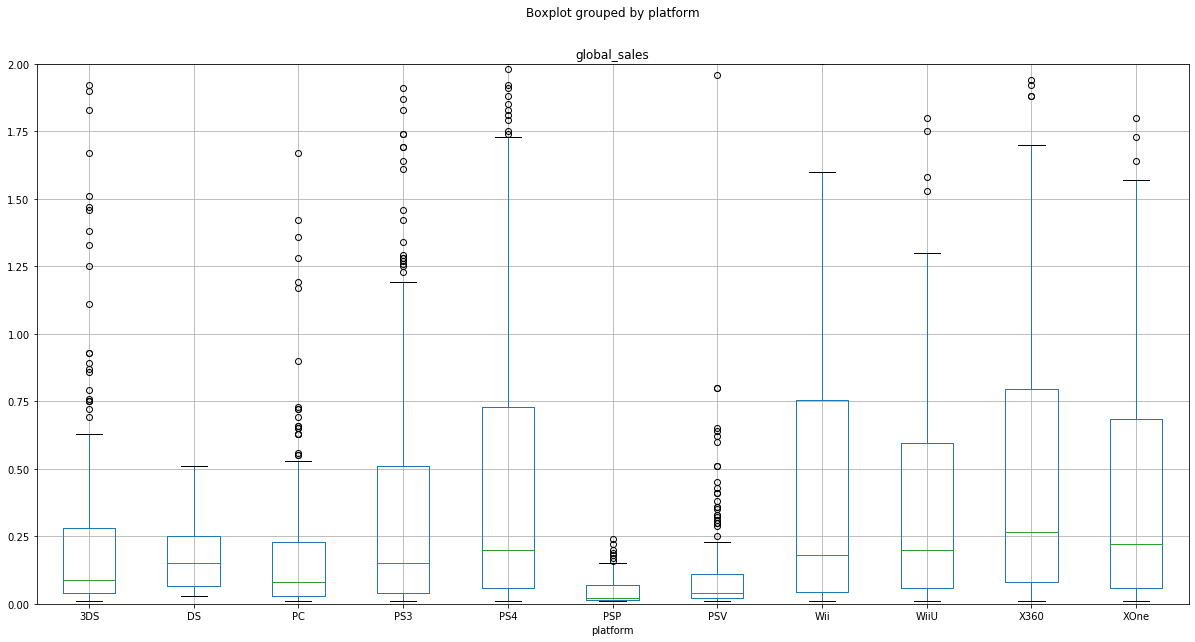

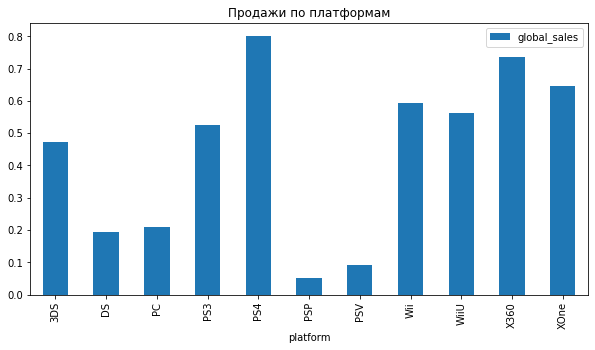

In [12]:
# строим график "ящик с усами" по глобальным продажам в разбивке по платформам
df_topical.boxplot(column = 'global_sales',by = 'platform',figsize = (20,10))
plt.ylim(0, 2)

#на "всякий случай" строим столбчатую диаграмму глобальных продаж по платформам 
df_topical.pivot_table(index = 'platform', values = 'global_sales').plot(kind = 'bar', title = 'Продажи по платформам', figsize = (10,5))
plt.show()

**Нижний ус упирается в 0. Граница верхних усов у всех разная, где-то 0,5, где-то 1 - в любом случае это граница нормального размаха. Всё, что находится за верхней границей - считается выбросами.  Они рисуются отдельными точками, но где-то сливаются в одну линию. Наверное, значения которые отсек верхний ус можно считать "редкими". Видно, насколько медиана (зелёная линия) не стремится к длинному хвосту высоких значений.**

**На столбчатой диаграмме более наглядно выглядят продажи по платформам.**

# Шаг 3.6

In [13]:
df_ps4 = df_topical.query('platform in "PS4"') # оставляем данные только по PS4
df_ps4.info()
display(df_ps4.head(20))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 31 to 16585
Data columns (total 12 columns):
name               392 non-null object
platform           392 non-null object
year_of_release    392 non-null int64
genre              392 non-null object
na_sales           392 non-null float64
eu_sales           392 non-null float64
jp_sales           392 non-null float64
other_sales        392 non-null float64
critic_score       252 non-null float64
user_score         257 non-null float64
rating             255 non-null object
global_sales       392 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 39.8+ KB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17
143,FIFA 15,PS4,2014,Sports,0.80,4.33,0.05,0.90,82.0,5.7,E,6.08
154,Destiny,PS4,2014,Shooter,2.49,2.07,0.16,0.92,76.0,6.1,T,5.64
171,Uncharted 4: A Thief's End,PS4,2016,Shooter,1.85,2.50,0.19,0.85,93.0,7.9,T,5.39


-0.031957110204556424


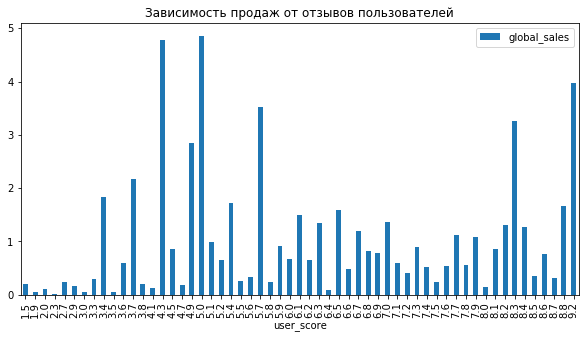

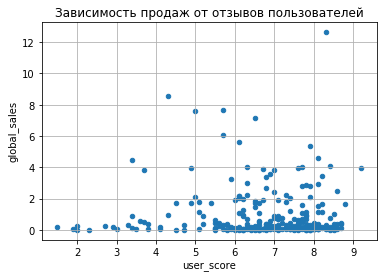

In [14]:
df_ps4.pivot_table(index = 'user_score', values = 'global_sales').plot(kind = 'bar', title = 'Зависимость продаж от отзывов пользователей', figsize = (10,5))
# строим график зависимости продаж от отзывов пользователей

df_ps4.plot(x='user_score', y='global_sales', kind='scatter',title = 'Зависимость продаж от отзывов пользователей', grid=True)

print(df_ps4['user_score'].corr(df_ps4['global_sales'])) # также проверяем кореляцию

0.40656790206178095


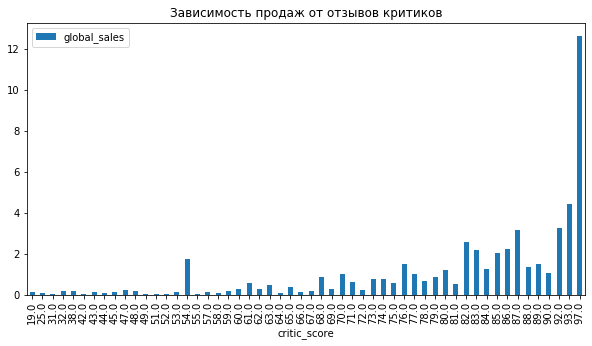

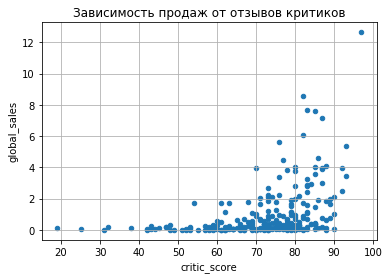

In [15]:
df_ps4.pivot_table(index = 'critic_score', values = 'global_sales').plot(kind = 'bar', title = 'Зависимость продаж от отзывов критиков', figsize = (10,5))
# строим график зависимости продаж от отзывов критиков

df_ps4.plot(x='critic_score', y='global_sales', kind='scatter',title = 'Зависимость продаж от отзывов критиков', grid=True)

print(df_ps4['critic_score'].corr(df_ps4['global_sales'])) # также проверяем кореляцию

**Для этого шага, я выбрал платформу "PlayStation 4".**

**Судя по графикам и кореляции, продажи игр на этой платформе не зависят от оценок пользователей.**

**От оценок критиков есть существенная зависимость, кореляция больше чем 0,4. По графику также заметна зависимость, особенно высокие продажи при оценке ближе к 10.**

In [16]:
#функция для создания сводной таблицы с продажами по какому-нибудь столбцу с процентами продаж

#def df_column_sales(df_name,column,sales):
#    df_temporary = df_name.pivot_table(index = [column], values = sales, aggfunc = 'sum')
#    df_temporary['%'] = (df_temporary[sales] / df_temporary[sales].sum() * 100).round(1)
#    return df_temporary

#df_topical_platform_sales = df_column_sales(df_topical, 'name', 'global_sales')
#display(df_topical_platform_sales.sort_values(by='global_sales', ascending=False))

# Шаг 3.7

-0.0011216242093378549
0.2812510848217569


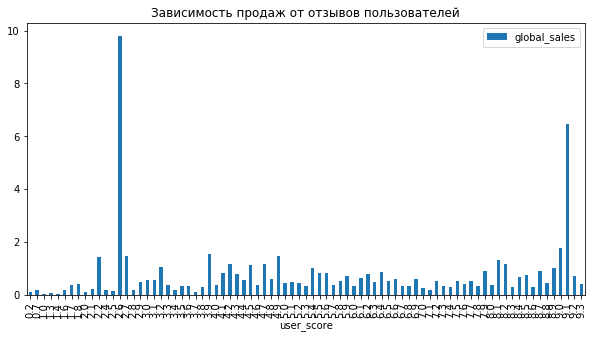

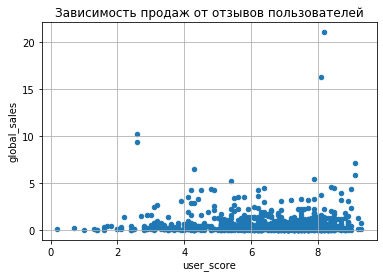

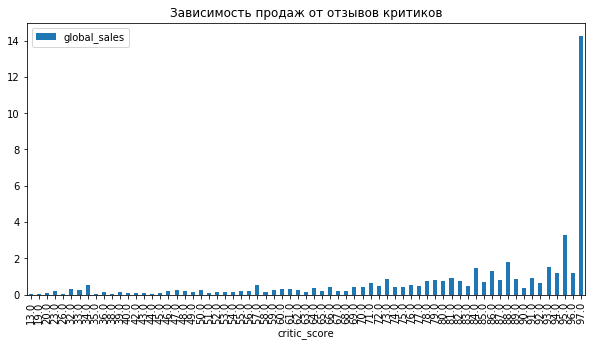

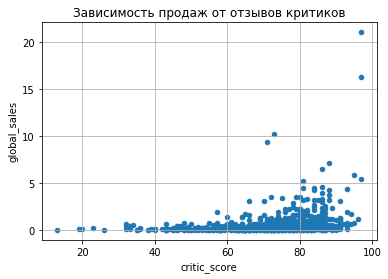

In [17]:
df_not_ps4 = df_topical.query('platform != "PS4"') # оставляем данные без PS4
#df_not_ps4.info()
#display(df_not_ps4.head(20))

df_not_ps4.pivot_table(index = 'user_score', values = 'global_sales').plot(kind = 'bar', title = 'Зависимость продаж от отзывов пользователей', figsize = (10,5))
# строим график зависимости продаж от отзывов пользователей

df_not_ps4.plot(x='user_score', y='global_sales', kind='scatter',title = 'Зависимость продаж от отзывов пользователей', grid=True)

print(df_not_ps4['user_score'].corr(df_not_ps4['global_sales'])) # также проверяем кореляцию


df_not_ps4.pivot_table(index = 'critic_score', values = 'global_sales').plot(kind = 'bar', title = 'Зависимость продаж от отзывов критиков', figsize = (10,5))
# строим график зависимости продаж от отзывов критиков

df_not_ps4.plot(x='critic_score', y='global_sales', kind='scatter',title = 'Зависимость продаж от отзывов критиков', grid=True)

print(df_not_ps4['critic_score'].corr(df_not_ps4['global_sales'])) # также проверяем кореляцию

**Судя по графикам и кореляции, продажи игр на всех вместе взятых платформах не зависят от оценок пользователей.**

**От оценок критиков есть зависимость, кореляция больше чем 0,28. По графику также заметна зависимость, особенно высокие продажи при оценке ближе к 10.**

**Отсюда сделаем вывод, что продажи что на отдельно взятой платформе, что на всех вместе взятых, не зависят от оценок пользователей. С оценками критиков ситуация другая, небольшая зависимость проявляется, и наиболее заметна при оценке близкой к 10.**

# Шаг 3.8

In [18]:
#print(df_topical['genre'].unique())

#создаем сводную таблицу для определения количества выпущенных игр по годам
df_genre_count = df_topical.pivot_table(index = ['genre'], values = 'name', aggfunc = 'count') 
df_genre_count = df_genre_count.rename(columns = {'name':'count'}) 

#добавляем столбец с процентами от общего количества
df_genre_count['%'] = (df_genre_count['count'] / df_genre_count['count'].sum() * 100).round(1)
display(df_genre_count.sort_values(by='count', ascending=False))


#создаем сводную таблицу для определения количества выпущенных игр по жанрам
df_genre_sum = df_topical.pivot_table(index = ['genre'], values = 'global_sales', aggfunc = 'sum')

#добавляем столбец с процентами от общей суммы продаж
df_genre_sum['%'] = (df_genre_sum['global_sales'] / df_genre_sum['global_sales'].sum() * 100).round(1)
display(df_genre_sum.sort_values(by='global_sales', ascending=False))



,count,%
genre,,
Action,766,34.3
Role-Playing,292,13.1
Adventure,245,11.0
Sports,214,9.6
Shooter,187,8.4
Misc,155,6.9
Racing,85,3.8
Fighting,80,3.6
Platform,74,3.3


,global_sales,%
genre,,
Action,321.87,29.5
Shooter,232.98,21.4
Sports,150.65,13.8
Role-Playing,145.89,13.4
Misc,62.82,5.8
Platform,42.63,3.9
Racing,39.89,3.7
Fighting,35.31,3.2
Adventure,23.64,2.2


**Жанрами, в которых выпускается больше всего игр являются : "Action","Role-Playing","Adventure","Sports","Shooter" и "Misc". На долю выпуска игр этих жанров приходится примерно 83,3%. Явный лидер : "Action" на долю выпуска игр этих жанров приходится 34,3%.**

**Самыми популярными жанрами  являются : "Action","Shooter","Sports" и "Role-Playing". На долю продаж игр этих жанров приходится примерно 78,1%. Явные лидеры : "Action" и "Shooter", на долю продаж игр этих жанров приходится 29,5% и 21,4% соответственно.**

**Аутсайдерами по продажам являются жанры : "Puzzle" и "Strategy", на долю продаж игр этих жанров приходится 0,3% и 0,9% соответственно.**

# Шаг 4. Составление портрета пользователя каждого региона

# Шаг 4.1

,na_sales,%
platform,,
PS4,108.74,24.8
XOne,93.12,21.3
X360,81.66,18.7
PS3,63.50,14.5
3DS,38.20,8.7


,na_sales,%
genre,,
Action,126.05,28.8
Shooter,109.74,25.1
Sports,65.27,14.9
Role-Playing,46.40,10.6
Misc,27.49,6.3


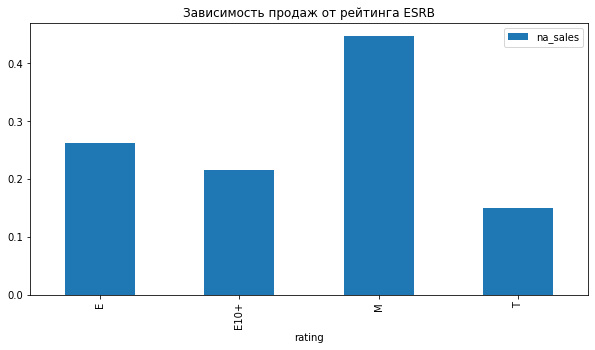

In [19]:
#создаем сводную таблицу суммарных продаж в Северной Америке по платформам
df_platform_na_sales = df_topical.pivot_table(index = ['platform'], values = 'na_sales', aggfunc = 'sum')

#добавляем столбец с процентами от общей суммы продаж
df_platform_na_sales['%'] = (df_platform_na_sales['na_sales'] / df_platform_na_sales['na_sales'].sum() * 100).round(1)
display((df_platform_na_sales.sort_values(by='na_sales', ascending=False)).head())



#создаем сводную таблицу суммарных продаж в Северной Америке по жанрам
df_genre_na_sales = df_topical.pivot_table(index = ['genre'], values = 'na_sales', aggfunc = 'sum')

#добавляем столбец с процентами от общей суммы продаж
df_genre_na_sales['%'] = (df_genre_na_sales['na_sales'] / df_genre_na_sales['na_sales'].sum() * 100).round(1)
display((df_genre_na_sales.sort_values(by='na_sales', ascending=False)).head())



# строим график зависимости продаж от рейтинга ESRB
df_topical.pivot_table(index = 'rating', values = 'na_sales').plot(kind = 'bar', title = 'Зависимость продаж от рейтинга ESRB', figsize = (10,5))
plt.show()


**Как показал анализ, самыми популярными платформами в Северной Америке за последние 4 года являются :"PlayStation 4", "Xbox One", "Xbox360","PlayStation 3" и "Nintendo 3DS". На долю продаж игр этих платформ приходится примерно 88%. Явные лидеры : "PlayStation 4" и "Xbox One", на долю продаж игр этих платформ приходится 24,8% и 21,3% соответственно.**

**Самыми популярными жанрами в Северной Америке являются : "Action","Shooter","Sports","Role-Playing" и "Misc". На долю продаж игр этих жанров приходится примерно 85,7%. Явные лидеры : "Action" и "Shooter", на долю продаж игр этих жанров приходится 28,8% и 25,1% соответственно.**

**Судя по графику, рейтинг ESRB достаточно сильно влияет на продажи компьютерных игр. В Северной Америке наибольшей популярностью пользуются игры с рейтингом "М"(17+), следующей по популярности является категория игр с рейтингом "Е"(для всех), но прилично "отстает" от лидера.** 

# Шаг 4.2

,eu_sales,%
platform,,
PS4,141.09,36.0
PS3,67.81,17.3
XOne,51.59,13.2
X360,42.52,10.8
3DS,30.96,7.9


,eu_sales,%
genre,,
Action,118.13,30.1
Shooter,87.86,22.4
Sports,60.52,15.4
Role-Playing,36.97,9.4
Racing,20.19,5.1


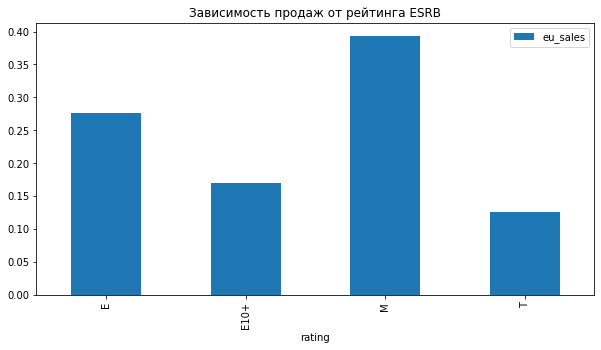

In [20]:
#создаем сводную таблицу суммарных продаж в Европе по платформам
df_platform_eu_sales = df_topical.pivot_table(index = ['platform'], values = 'eu_sales', aggfunc = 'sum')

#добавляем столбец с процентами от общей суммы продаж
df_platform_eu_sales['%'] = (df_platform_eu_sales['eu_sales'] / df_platform_eu_sales['eu_sales'].sum() * 100).round(1)
display((df_platform_eu_sales.sort_values(by='eu_sales', ascending=False)).head())


#создаем сводную таблицу суммарных продаж в Европе по жанрам
df_genre_eu_sales = df_topical.pivot_table(index = ['genre'], values = 'eu_sales', aggfunc = 'sum')

#добавляем столбец с процентами от общей суммы продаж
df_genre_eu_sales['%'] = (df_genre_eu_sales['eu_sales'] / df_genre_eu_sales['eu_sales'].sum() * 100).round(1)
display((df_genre_eu_sales.sort_values(by='eu_sales', ascending=False)).head())


# строим график зависимости продаж от от рейтинга ESRB
df_topical.pivot_table(index = 'rating', values = 'eu_sales').plot(kind = 'bar', title = 'Зависимость продаж от рейтинга ESRB', figsize = (10,5))
plt.show()


**Самыми популярными платформами в Европе за последние 4 года являются :"PlayStation 4","PlayStation 3", "Xbox One", "Xbox360" и "Nintendo 3DS". На долю продаж игр этих платформ приходится примерно 85,2%. Явный лидер : "PlayStation 4" , на долю продаж игр этой платформы приходится 36%.**

**Самыми популярными жанрами в Европе являются : "Action","Shooter","Sports","Role-Playing" и "Racing". На долю продаж игр этих жанров приходится примерно 82,4%. Явные лидеры : "Action" и "Shooter", на долю продаж игр этих жанров приходится 30,1% и 22,4% соответственно.**

**Судя по графику, в Европе наибольшей популярностью пользуются игры с рейтингом "М"(17+), следующей по популярности является категория игр с рейтингом "Е"(для всех).** 

# Шаг 4.3

,jp_sales,%
platform,,
3DS,67.81,48.2
PS3,23.35,16.6
PSV,18.59,13.2
PS4,15.96,11.3
WiiU,10.88,7.7


,jp_sales,%
genre,,
Role-Playing,51.04,36.3
Action,40.49,28.8
Misc,9.20,6.5
Fighting,7.65,5.4
Shooter,6.61,4.7


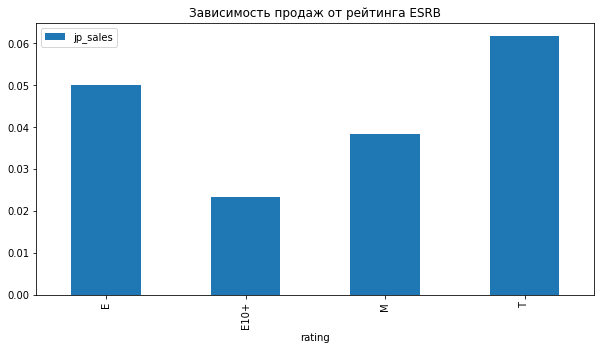

In [21]:
#создаем сводную таблицу суммарных продаж в Японии по платформам
df_platform_jp_sales = df_topical.pivot_table(index = ['platform'], values = 'jp_sales', aggfunc = 'sum')

#добавляем столбец с процентами от общей суммы продаж
df_platform_jp_sales['%'] = (df_platform_jp_sales['jp_sales'] / df_platform_jp_sales['jp_sales'].sum() * 100).round(1)
display((df_platform_jp_sales.sort_values(by='jp_sales', ascending=False)).head())


#создаем сводную таблицу суммарных продаж в Японии по жанрам
df_genre_jp_sales = df_topical.pivot_table(index = ['genre'], values = 'jp_sales', aggfunc = 'sum')

#добавляем столбец с процентами от общей суммы продаж
df_genre_jp_sales['%'] = (df_genre_jp_sales['jp_sales'] / df_genre_jp_sales['jp_sales'].sum() * 100).round(1)
display((df_genre_jp_sales.sort_values(by='jp_sales', ascending=False)).head())


# строим график зависимости продаж от от рейтинга ESRB
df_topical.pivot_table(index = 'rating', values = 'jp_sales').plot(kind = 'bar', title = 'Зависимость продаж от рейтинга ESRB', figsize = (10,5))
plt.show()
# строим график зависимости продаж от 


**Самыми популярными платформами в Японии за последние 4 года являются : "Nintendo 3DS","PlayStation 3","PSV","PlayStation 4"и "WiiU". На долю продаж игр этих платформ приходится примерно 97%. Явный лидер : "Nintendo 3DS" , на долю продаж игр этой платформы приходится 36,3%.**

**Самыми популярными жанрами в Японии являются : "Role-Playing","Action", "Misc", "Fighting", "Shooter". На долю продаж игр этих жанров приходится примерно 81,7%. Явные лидеры : "Role-Playing" и "Action", на долю продаж игр этих жанров приходится 36,3% и 28,8% соответственно.**

**Судя по графику, в Японии наибольшей популярностью пользуются игры с рейтингом "Т"(Подросток), следующей по популярности является категория игр с рейтингом "Е"(для всех), ну и замыкает тройку категория игр с рейтингом "М"(17+).**

# Шаг 5. Проверка гипотез

# Шаг 5.1

***По условиям, поставленым в проекте, нужно проверить одну из гипотез: "средние рейтинги пользователей платформы "Xbox One" и "PC" различаются". Следовательно так и формулируем гипотезу Ho. Гипотезу H1 формулируем так: "средние рейтинги пользователей платформы "Xbox One" и "PC" не различаются" .***

In [22]:
df_xbox_one = df_topical.query('platform in "XOne"')     # оставляем данные только по платформе "Xbox One"
df_xbox_one.dropna(subset = ['user_score'], inplace=True)# удаляем строки с пропусками оценок, т.к. выборка все равно останется
                                                         # большой

df_pc = df_topical.query('platform in "PC"')             # оставляем данные только по платформе "Xbox One"
df_pc.dropna(subset = ['user_score'], inplace=True)      # удаляем строки с пропусками оценок, т.к. выборка все равно останется
                                                         # большой
    
df_xbox_rating = pd.Series(df_xbox_one['user_score'].to_list())#создаем списки оценок пользователей по платформам
df_pc_rating = pd.Series(df_pc['user_score'].to_list())

alpha = 0.05#  критический уровень статистической значимости

results = st.ttest_ind(df_xbox_rating, df_pc_rating, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:# сравниваем получившееся p-значение с заданным уровнем статистической значимости:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


# Шаг 5.2

***Нужно проверить гипотезу: "средние рейтинги пользователей жанра "Action" и "Sports" различаются". Следовательно так и формулируем гипотезу Ho. Гипотезу H1 формулируем так: "средние рейтинги пользователей жанра "Action" и "Sports" не различаются" .***

In [23]:
df_action = df_topical.query('genre in "Action"')      # оставляем данные только по жанру "Action"
df_action.dropna(subset = ['user_score'], inplace=True)# удаляем строки с пропусками оценок, т.к. выборка все равно останется
                                                       # большой
    
df_sports = df_topical.query('genre in "Sports"')      # оставляем данные только по жанру "Sports"
df_sports.dropna(subset = ['user_score'], inplace=True)# удаляем строки с пропусками оценок, т.к. выборка все равно останется
                                                       # большой
    
df_action_rating = pd.Series(df_action['user_score'].to_list())#создаем списки оценок пользователей по жанрам
df_sports_rating = pd.Series(df_sports['user_score'].to_list())

alpha = 0.05#  критический уровень статистической значимости

results = st.ttest_ind(df_action_rating, df_sports_rating, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:# сравниваем получившееся p-значение с заданным уровнем статистической значимости:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


**Использовал специальный метод для проверки гипотез о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind (array1, array2,equal_var) .**

# Шаг 6. Общий вывод

**Согласно  исследованиям проведенным в соответствии с ТЗ можно подвести краткие итоги и сделать прогнозы :**

**1. Не всегда топовые по продажам платформы являются перспективными, они могут быть уже "отработаным материалом" , например "PlayStation 2", "PlayStation 3","Xbox360". Их время закончилось, т.к. срок "жизни" платформы примерно 10 лет. В то же время есть платформы, которые еще не вышли в топ по продажам, но и не выработали свой потенциал, например "PlayStation 4","Xbox One", "Nintendo DS". Так же определенный объем продаж будет приносить "вечный" "PC".**

**Поэтому на 2017 год упор надо делать на "PlayStation 4","Xbox One", "Nintendo DS","вечный" "PC", если не планируется какой-то новой платформы. Продажи на этих платформах тоже прошли свой пик и падают.**

**2. Продажи что на отдельно взятой платформе, что на всех вместе взятых, не зависят от оценок пользователей. С оценками критиков ситуация другая, небольшая зависимость проявляется, и наиболее заметна при оценке близкой к 10.**

**3. Самыми популярными жанрами в общемировом пространстве являются : "Action","Shooter","Sports" и "Role-Playing". На долю продаж игр этих жанров приходится примерно 78,1%. Явные лидеры : "Action" и "Shooter", на долю продаж игр этих жанров приходится 29,5% и 21,4% соответственно. Аутсайдерами по продажам являются жанры : "Puzzle" и "Strategy", на долю продаж игр этих жанров приходится 0,3% и 0,9% соответственно.**

**4. Если смотреть на отдельные регионы :**

**В Северной Америке наиболее перспективными являются платформы : "PlayStation 4", "Xbox One", "Xbox360","PlayStation 3" и "Nintendo 3DS". По жанрам лидируют "Action","Shooter","Sports","Role-Playing" и "Misc". Также нужно учесть рейтинг ESRB, здесь наиболее популярные игры с рейтингом "М"(17+) и "Е"(для всех). Т.е. "самое прибыльное направление" : "PlayStation 4" + "Action" + "М".**

**Самыми перспективными платформами в Европе являются :"PlayStation 4","PlayStation 3", "Xbox One", "Xbox360" и "Nintendo 3DS".По жанрам лидерами являются : "Action","Shooter","Sports","Role-Playing" и "Racing". По рейтингу ESRB : "М"(17+) и "Е"(для всех). Т.е. "самое прибыльное направление" : "PlayStation 4" + "Action" + "М", как и в Северной Аменрике.**

**В Японии ситуация другая, самыми популярными платформами являются : "Nintendo 3DS","PlayStation 3","PSV","PlayStation 4"и "WiiU".Самыми популярными жанрами в Японии являются : "Role-Playing","Action", "Misc", "Fighting", "Shooter". По рейтингу ESRB : "Т"(подросток) и "Е"(для всех). Т.е. "самое прибыльное направление" : "Nintendo 3DS" + "Role-Playing" +  "Т".**

**5. При проверке гипотез выяснилось, средние рейтинги пользователей платформы "Xbox One" и "PC" различаются, а средние рейтинги пользователей жанра "Action" и "Sports" не различаются.**